In [77]:
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')
    print(1)
except:
    print('NOT IPYTHON')

import os
import socket
import logging
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import math


from scipy.ndimage.filters import gaussian_filter
from tifffile.tifffile import imsave, imread

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
import caiman.source_extraction.cnmf as cnmf
from caiman.paths import caiman_datadir

from pathlib import Path

import cv2

try:
    cv2.setNumThreads(0)
except:
    pass



import bokeh.plotting as bpl
bpl.output_notebook()
logging.basicConfig(format=
                            "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                            # filename="/tmp/caiman.log",
                            level=logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1


Loading BokehJS ...

## FUNCTIONS

In [82]:
def start_cluster(): 
    """
    start a cluster for parallel processing 
    
    (if a cluster already exists it will be closed and a new session will be opened)
    """
    if 'dview' in locals():
        cm.stop_server(dview=dview)
    c, dview, n_processes = cm.cluster.setup_cluster(
        backend='local', n_processes=None, single_thread=False)
    return c, dview, n_processes

def restart_cluster():
    """
    restart cluster to clean up memory
    """
    cm.stop_server(dview=dview)
    c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)
    return c, dview, n_processes

def montage(Y_, ncols=4):
    d1, d2, d3 = Y_.shape
    print(d3)
    
    nrows = math.ceil(d3/ncols)
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))
    axlist = axs.flat
    #for z, ax in enumerate(axs.flat):
    images = []
    for z in range(d3):
        ax = axlist[z]
        images.append(ax.imshow(Y_[:,:,z], aspect='equal', cmap='viridis'))
        ax.set_title(str(z))
        ax.set_xticks([])
        ax.set_yticks([])
        
    vmin = max(image.get_array().min() for image in images)
    vmax = min(image.get_array().max() for image in images)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for im in images:
        im.set_norm(norm)
    plt.show()

def orthoplot(Y_, type='corr'):
    T, d1, d2, d3 = Y_.shape
    
    if type == 'corr':
        Cn = cm.local_correlations(Y_, swap_dim=False)
    elif type == 'mean':
        Cn = cm.mean(0)
    x, y = (int(1.2 * (d1 + d3)), int(1.2 * (d2 + d3)))
    scale = 6/x
    fig = plt.figure(figsize=(scale*x, scale*y))
    axz = fig.add_axes([1-d1/x, 1-d2/y, d1/x, d2/y])
    plt.imshow(Cn.max(2).T, cmap='gray')
    plt.title('Max.proj. z')
    plt.xlabel('x')
    plt.ylabel('y')
    axy = fig.add_axes([0, 1-d2/y, d3/x, d2/y])
    plt.imshow(Cn.max(0), cmap='gray')
    plt.title('Max.proj. x')
    plt.xlabel('z')
    plt.ylabel('y')
    axx = fig.add_axes([1-d1/x, 0, d1/x, d3/y])
    plt.imshow(Cn.max(1).T, cmap='gray')
    plt.title('Max.proj. y')
    plt.xlabel('x')
    plt.ylabel('z');
    plt.show()

## Set directory path, fly and movie info

In [50]:
comp_name = socket.gethostname()
print(f"COMPUTER: {comp_name}")

if comp_name == 'gerty':
    PRJ_DIR = Path("/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing")
elif comp_name == 'hal':
    PRJ_DIR = Path("/local/gerty/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing")


flydate = "2021-08-30"
flynum = 2
movie = "movie_001"
block = 0

FLY_DIR = PRJ_DIR.joinpath('data', 'processed_data', flydate, str(flynum))
MOV_DIR = FLY_DIR.joinpath(movie)

if block is not None:
    TIFF_DIR = MOV_DIR.joinpath(str(block))
else:
    TIFF_DIR = MOV_DIR
    
files = sorted(list(TIFF_DIR.glob("stk_*.tif")))


print(f"\nPRJ_DIR: {PRJ_DIR}")
print(f"FLY_DIR: {FLY_DIR.relative_to(PRJ_DIR)}")
print(f"MOV_DIR: {MOV_DIR.relative_to(PRJ_DIR)}")
print(f"TIFF_DIR: {TIFF_DIR.relative_to(PRJ_DIR)}")

for item in files:
    print(f"\t{item.relative_to(TIFF_DIR)}")

COMPUTER: gerty

PRJ_DIR: /media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing
FLY_DIR: data/processed_data/2021-08-30/2
MOV_DIR: data/processed_data/2021-08-30/2/movie_001
TIFF_DIR: data/processed_data/2021-08-30/2/movie_001/0
	stk_0000.tif
	stk_0001.tif
	stk_0002.tif


## Load, reorder, and re-save tiff files

Load volumetric tiff files in `(T, d3, d2, d1)` order, and shuffle axes to `(T, d1, d2, d3)`.

Loaded tiff files will have names like __stk_0001.tif__ , and will be reordered in __cm_0001.tif__

In [110]:
print(Y.dtype)

uint16


In [123]:

#m_orig = cm.load_movie_chain([str(item) for item in files], is3D=True)
#print(f"\tOriginal shape: {m_orig.shape}")

#m_orig = m_orig.swapaxes(1, 3)
#print(m_orig.shape)
#print(type(m_orig.data))

#Cm = m_orig.mean(0)
#montage(Cm)
#print(m_orig.shape)
#m_orig.save(str(TIFF_DIR.joinpath('stkcat.tif')), to32=False)
#np.save(str(TIFF_DIR.joinpath('stkcat.npy')), np.asarray(m_orig))

# save as multipage tiffs, correctly ordered
fix_tiffs = True
if fix_tiffs:
    T = m_orig.shape[0]  # total number of frames for the file
    L = 323  # length of each individual file

    for i, t in enumerate(np.arange(0,T,L)):
        newname = f"cm_{str(i).zfill(4)}.tif"
        newfile = str(TIFF_DIR.joinpath(newname))
        print(newfile)
        print(f"{newname}, size: {m_orig[t:t+L].shape}, frames: {t} to {t+L-1}")
        m_orig[t:t+L].save(newfile)


convert_tiff_stacks=False
if convert_tiff_stacks:
    for f in files:
        # load movie
        Y = cm.load(f, is3D=True, outtype=np.uint16)
        shape1 = Y.shape
        print("LOADED: {f}")

        # rearrange axes
        Y = Y.swapaxes(1,3)
        shape2 = Y.shape
        
        # load tiff file
        #Y = imread(f)
        #shape1 = Y.shape
        #Y2 = np.moveaxis(Y.T, -1, 0)
        #shape2 = Y2.shape

        # replace 'stk' prefix with 'cm'
        newfile = str(f.name).replace('stk', 'cm')
        newfile = str(f.parent.joinpath(newfile))
        print(newfile)
        print(f"SAVE PATH: {newfile}")
        
        # save reordered tiff file
        Y.save(newfile)
        #imsave(f.parent.joinpath(newfile), Y2)

        # print name, shape info
        print(f"\n{f.parent.relative_to(PRJ_DIR)}")
        print(f"\t{f.name}, {shape1} ==> {newfile}, {shape2}")

    84810166 [timeseries.py:                save():170] [30935] Parsing extension .tif


/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0000.tif
cm_0000.tif, size: (323, 256, 256, 16), frames: 0 to 322


    84810430 [timeseries.py:                 foo():177] [30935] 0 frames saved
    84810572 [timeseries.py:                 foo():177] [30935] 200 frames saved
    84822676 [timeseries.py:                save():170] [30935] Parsing extension .tif


/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0001.tif
cm_0001.tif, size: (323, 256, 256, 16), frames: 323 to 645


    84824070 [timeseries.py:                 foo():177] [30935] 0 frames saved
    84824220 [timeseries.py:                 foo():177] [30935] 200 frames saved
    84841825 [timeseries.py:                save():170] [30935] Parsing extension .tif


/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0002.tif
cm_0002.tif, size: (323, 256, 256, 16), frames: 646 to 968


    84844409 [timeseries.py:                 foo():177] [30935] 0 frames saved
    84844544 [timeseries.py:                 foo():177] [30935] 200 frames saved
    84862717 [timeseries.py:                save():170] [30935] Parsing extension .tif


/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0003.tif
cm_0003.tif, size: (323, 256, 256, 16), frames: 969 to 1291


    84864359 [timeseries.py:                 foo():177] [30935] 0 frames saved
    84864494 [timeseries.py:                 foo():177] [30935] 200 frames saved
    84882553 [timeseries.py:                save():170] [30935] Parsing extension .tif


/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0004.tif
cm_0004.tif, size: (323, 256, 256, 16), frames: 1292 to 1614


    84884519 [timeseries.py:                 foo():177] [30935] 0 frames saved
    84884654 [timeseries.py:                 foo():177] [30935] 200 frames saved
    84900905 [timeseries.py:                save():170] [30935] Parsing extension .tif


/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0005.tif
cm_0005.tif, size: (323, 256, 256, 16), frames: 1615 to 1937


    84902118 [timeseries.py:                 foo():177] [30935] 0 frames saved
    84902254 [timeseries.py:                 foo():177] [30935] 200 frames saved
    84919940 [timeseries.py:                save():170] [30935] Parsing extension .tif


/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0006.tif
cm_0006.tif, size: (323, 256, 256, 16), frames: 1938 to 2260


    84922036 [timeseries.py:                 foo():177] [30935] 0 frames saved
    84922171 [timeseries.py:                 foo():177] [30935] 200 frames saved
    84943201 [timeseries.py:                save():170] [30935] Parsing extension .tif


/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0007.tif
cm_0007.tif, size: (323, 256, 256, 16), frames: 2261 to 2583


    84946008 [timeseries.py:                 foo():177] [30935] 0 frames saved
    84946143 [timeseries.py:                 foo():177] [30935] 200 frames saved
    84963577 [timeseries.py:                save():170] [30935] Parsing extension .tif


/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0008.tif
cm_0008.tif, size: (323, 256, 256, 16), frames: 2584 to 2906


    84964086 [timeseries.py:                 foo():177] [30935] 0 frames saved
    84964222 [timeseries.py:                 foo():177] [30935] 200 frames saved


## Load movie chain

In [125]:
tiff_files = sorted(list(TIFF_DIR.glob("cm_*.tif")))
tiff_files = [str(item) for item in tiff_files]

for f in tiff_files:
    print(f)
    
#fname = [str(item) for item in sorted(list(TIFF_DIR.glob("stkcat.npy")))]
#if len(fname)==1:
#    fname = fname[0]
#print(fname)

m_orig = cm.load_movie_chain(tiff_files, is3D=True)
print(m_orig.shape)

/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0000.tif
/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0001.tif
/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0002.tif
/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0003.tif
/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0004.tif
/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0005.tif
/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/

100%|█████████████████████████████████████████████| 9/9 [04:13<00:00, 28.21s/it]


(2907, 256, 256, 16)


## Display movie

(2907, 256, 256, 16)
16


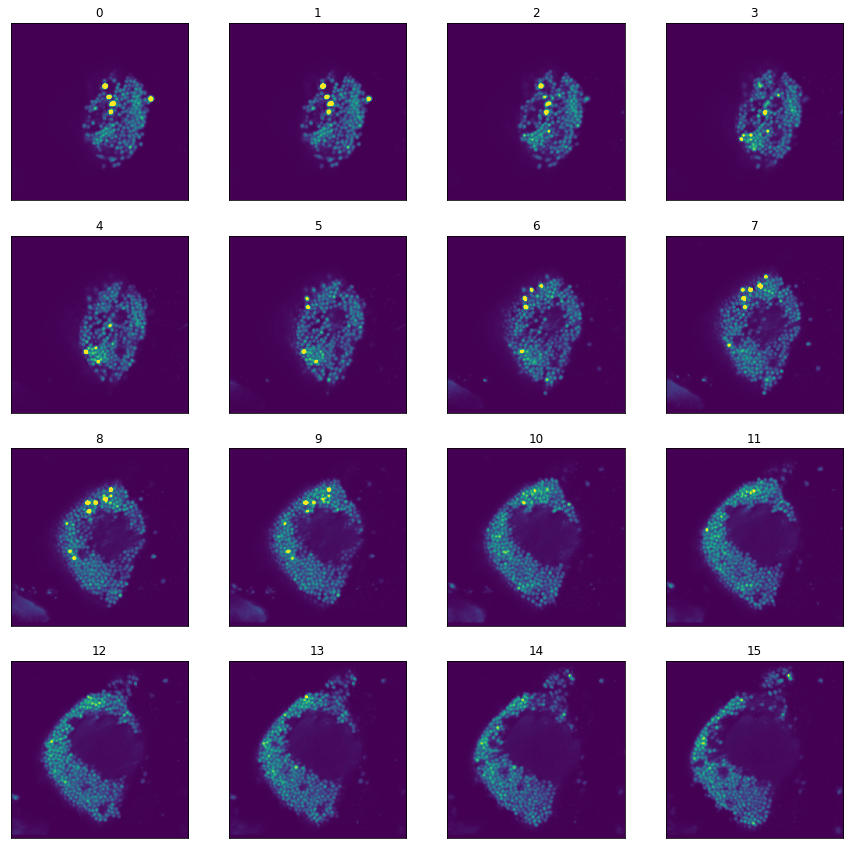

In [126]:
print(f"movie size: {m_orig.shape}")

#orthoplot(m_orig)
Cm = m_orig.mean(0)
montage(Cm)


## Motion correction

Set parameters. Right now, dimensions are in order `(T, d3, d2, d1)`

In [135]:
#%% start the cluster (if a cluster already exists terminate it)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=11, single_thread=False)

    87788506 [cluster.py:         stop_server():348] [30935] stop_cluster(): done


In [136]:
# motion correction parameters

for f in tiff_files:
    print(f)
    
opts_dict = {'fnames': tiff_files,
            'num_frames_split': 323,
            'strides': [64, 64, 3],    # start a new patch for pw-rigid motion correction every x pixels
            'overlaps': [16, 16, 1],   # overlap between pathes (size of patch strides+overlaps)
            'max_shifts': [16, 16, 2],   # maximum allowed rigid shifts (in pixels)
            'max_deviation_rigid': 5,  # maximum shifts deviation allowed for patch with respect to rigid shifts
            'pw_rigid': False,         # flag for performing non-rigid motion correction
            'is3D': True,
            'use_cuda': False,
            #'border_nan': 'min',
            # 'shifts_opencv': False
            }

opts = cnmf.params.CNMFParams(params_dict=opts_dict)

# first we create a motion correction object with the parameters specified
# note that the file is not loaded in memory
mc = cm.motion_correction.MotionCorrect(tiff_files, dview=dview, **opts.get_group('motion'))

    87799100 [params.py:                 set():971] [30935] Changing key fnames in group data from None to ["/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0000.tif", "/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0001.tif", "/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0002.tif", "/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0003.tif", "/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0004.tif", "/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08

/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0000.tif
/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0001.tif
/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0002.tif
/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0003.tif
/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0004.tif
/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0005.tif
/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/

    87802283 [params.py:   check_consistency():940] [30935] is3D=True, hence setting key indices automatically to (slice(None, None, None), slice(None, None, None), slice(None, None, None))


### Start cluster

In [139]:
#print(mc.indices)
#print(opts)
print(os.environ.get('MKL_NUM_THREADS'))
print(os.environ.get('OPENBLAS_NUM_THREADS'))

1
1


## Piecewide rigid motion correction

In [134]:
%%capture
#%% Run motion correction using NoRMCorre
mc.motion_correct(save_movie=True)

    85781978 [motion_correction.py:motion_correct_pwrigid():355] [30935] Generating template by rigid motion correction
    85781979 [motion_correction.py:motion_correct_rigid():293] [30935] Entering Rigid Motion Correction
    85781979 [motion_correction.py:motion_correct_rigid():294] [30935] -0.0
    85783097 [motion_correction.py:motion_correct_batch_rigid():2816] [30935] Adding to movie -0.0
    85783098 [motion_correction.py:motion_correct_batch_rigid():2822] [30935] 0
    85783100 [motion_correction.py:motion_correct_batch_rigid():2826] [30935] saving!
    85783281 [motion_correction.py:motion_correction_piecewise():3100] [30935] Number of Splits: 1
    85783282 [motion_correction.py:motion_correction_piecewise():3142] [30935] Processing: frames: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  

    86200069 [motion_correction.py:motion_correction_piecewise():3157] [30935] ** Finished parallel motion correction **
    86201193 [motion_correction.py:motion_correct_batch_rigid():2816] [30935] Adding to movie -0.0
    86201194 [motion_correction.py:motion_correct_batch_rigid():2822] [30935] 0
    86201195 [motion_correction.py:motion_correct_batch_rigid():2826] [30935] saving!
    86201344 [motion_correction.py:motion_correction_piecewise():3100] [30935] Number of Splits: 1
    86201346 [motion_correction.py:motion_correction_piecewise():3142] [30935] Processing: frames: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 10

    86626211 [motion_correction.py:motion_correct_batch_rigid():2822] [30935] 0
    86626213 [motion_correction.py:motion_correct_batch_rigid():2826] [30935] saving!
    86626377 [motion_correction.py:motion_correction_piecewise():3100] [30935] Number of Splits: 1
    86626378 [motion_correction.py:motion_correction_piecewise():3142] [30935] Processing: frames: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [23]:
fname_new = cm.save_memmap(mc.mmap_file, base_name='memmap_', order='C',
                           border_to_0=0, dview=dview) # exclude borders

# now load the file
#load frames in python format (T x X x Y)
Yr, dims, T = cm.load_memmap(fname_new)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
    
    
#m_rig = cm.load_movie_chain(mc.fname_tot_rig, is3D=True)
#print(m_rig.shape)

#m_rig[...,5].play(magnification=2)
#print(mc.fname_tot_rig)

  0%|                                                     | 0/3 [00:00<?, ?it/s]     4945556 [movies.py:                load():1718] [9315] loading mmap file in memory
     5026505 [movies.py:                load():1721] [9315] mmap
 33%|███████████████                              | 1/3 [01:21<02:42, 81.05s/it]     5026604 [movies.py:                load():1718] [9315] loading mmap file in memory
     5098297 [movies.py:                load():1721] [9315] mmap
 67%|██████████████████████████████               | 2/3 [02:32<01:15, 75.61s/it]     5098468 [movies.py:                load():1718] [9315] loading mmap file in memory
     5164017 [movies.py:                load():1721] [9315] mmap
100%|█████████████████████████████████████████████| 3/3 [03:38<00:00, 72.85s/it]


(2907, 256, 256, 16)


In [54]:
mc.mmap_file

AttributeError: 'MotionCorrect' object has no attribute 'mmap_file'

In [30]:
%%capture
fig, axs = plt.subplots(4, 4)
for z, ax in enumerate(axs.flat):
    ax.imshow(mc.total_template_rig[:,:,z], aspect='equal', cmap='gray')
    ax.set_title(str(z))
plt.show()
print(mc.total_template_rig.shape)

     4374728 [font_manager.py:    _findfont_cached():1329] [30935] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
     4374729 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
     4374730 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
     4374731 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
     4374732 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
     4374733 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
     4374734 [font_manager.py:    _findfont_cache

     4374765 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Oblique.ttf) oblique normal 500 normal>) = 11.145
     4374765 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Times New Roman' (times.ttf) normal normal 400 normal>) = 10.05
     4374766 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Tlwg Mono' (TlwgMono.ttf) normal normal 500 normal>) = 10.145
     4374769 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Alegreya Sans' (Alegreya_Sans_Ultra_Bold_Italic.ttf) italic normal 800 normal>) = 11.43
     4374771 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Lato' (Lato-Semibold.ttf) normal normal 600 normal>) = 10.24
     4374772 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'UnPilgia' (UnPilgia.ttf) normal normal 400 normal>) = 10.05
     4374773 [font_manager.py:    _findfont_cached():1

     4374808 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'KacstNaskh' (KacstNaskh.ttf) normal normal 500 normal>) = 10.145
     4374809 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Times New Roman' (Times_New_Roman.ttf) normal normal 400 normal>) = 10.05
     4374809 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'IBM Plex Mono' (IBM_Plex_Mono_Italic.ttf) italic normal 400 normal>) = 11.05
     4374810 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Universalis ADF Std' (UniversalisADFStd-Oblique.otf) oblique normal 400 normal>) = 11.05
     4374810 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'IBM Plex Mono' (IBM_Plex_Mono_Bold_Italic.ttf) italic normal 700 normal>) = 11.335
     4374811 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'msbm10' (msbm10.ttf) normal normal 400 normal>) = 10.05
     4374811 [fo

     4374837 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Georgia' (Georgia_Bold_Italic.ttf) italic normal 700 normal>) = 11.335
     4374838 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed.ttf) normal normal 400 condensed>) = 0.25
     4374838 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Courier New' (cour.ttf) normal normal 400 normal>) = 10.05
     4374839 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'GFS Didot' (GFSDidotBold.otf) normal normal 700 normal>) = 10.335
     4374839 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Bitstream Vera Sans' (VeraIt.ttf) oblique normal 400 normal>) = 1.9590909090909092
     4374840 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Impact' (Impact.ttf) normal normal 400 normal>) = 10.05
     4374841 [font_manager.py:    _findfont_cache

     4374871 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Umpush' (Umpush-LightOblique.ttf) oblique normal 300 normal>) = 11.145
     4374871 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Courier Prime' (Courier_Prime_Italic.ttf) italic normal 400 normal>) = 11.05
     4374872 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Universalis ADF Std' (UniversalisADFStd-BoldOblique.otf) oblique normal 700 normal>) = 11.335
     4374873 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'IBM Plex Sans' (IBM_Plex_Sans_Bold.ttf) normal normal 700 normal>) = 10.335
     4374873 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
     4374874 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'GFS Gazis' (GFSGazis.otf) normal normal 400 normal>) = 10.05
     4374874 [font_

     4374901 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'KacstOffice' (KacstOffice.ttf) normal normal 500 normal>) = 10.145
     4374901 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Lato' (Lato-Heavy.ttf) normal normal 800 normal>) = 10.43
     4374902 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Norasi' (Norasi-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
     4374907 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'GFS Didot' (GFSDidotBoldItalic.otf) italic normal 700 normal>) = 11.335
     4374908 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Purisa' (Purisa-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
     4374909 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Roboto' (Roboto_Regular.ttf) normal normal 400 normal>) = 10.05
     4374909 [font_manager.py:    _findfont_cached():1341] 

     4374934 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Kinnari' (Kinnari-Italic.ttf) italic normal 500 normal>) = 11.145
     4374934 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Laksaman' (Laksaman.ttf) normal normal 400 normal>) = 10.05
     4374935 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Times New Roman' (timesbi.ttf) italic normal 700 normal>) = 11.335
     4374935 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'KacstOne' (KacstOne-Bold.ttf) normal normal 700 normal>) = 10.335
     4374937 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Trebuchet MS' (Trebuchet_MS_Italic.ttf) italic normal 400 normal>) = 11.05
     4374937 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Loma' (Loma-Oblique.ttf) oblique normal 400 normal>) = 11.05
     4374938 [font_manager.py:    _findfont_cached():1341] [30935

     4374963 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Khmer OS' (KhmerOS.ttf) normal normal 400 normal>) = 10.05
     4374964 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Universalis ADF Cd Std' (UniversalisADFCdStd-Bold.otf) normal normal 700 normal>) = 10.335
     4374965 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
     4374965 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
     4374966 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'IBM Plex Sans' (IBM_Plex_Sans_Semi_Bold_Italic.ttf) italic normal 600 normal>) = 11.24
     4374967 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'IBM Plex Mono' (IBM_Plex_Mono_Ultra_Light.ttf) normal normal 200 norm

     4374992 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'UnDinaru' (UnDinaruBold.ttf) normal normal 700 normal>) = 10.335
     4374993 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'GFS BodoniClassic' (GFSBodoniClassic.otf) normal normal 400 normal>) = 10.05
     4374993 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal 700 normal>) = 10.335
     4374995 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Linux Libertine O' (LinLibertine_RBI.otf) italic normal 700 normal>) = 11.335
     4374996 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal 700 normal>) = 11.335
     4374997 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Kinnari' (Kinnari.ttf) normal normal 500 normal>) = 10.145
     4374998 [font_manager.py:    _findfont_cached():1

     4375026 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335
     4375027 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Garuda' (Garuda.ttf) normal normal 400 normal>) = 10.05
     4375028 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Linux Biolinum O' (LinBiolinum_R.otf) normal normal 400 normal>) = 10.05
     4375029 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal 700 normal>) = 10.335
     4375029 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'NanumMyeongjo' (NanumMyeongjoBold.ttf) normal normal 600 normal>) = 10.24
     4375030 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Alegreya Sans' (Alegreya_Sans_Ultra_Bold.ttf) normal normal 800 normal>) = 10.43
     4375031 [font_manager.py

     4375073 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
     4375074 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
     4375074 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
     4375075 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
     4375075 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
     4375078 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335


     4375108 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335
     4375108 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Gillius ADF No2 Cd' (GilliusADFNo2Cd-Italic.otf) italic normal 400 normal>) = 11.05
     4375109 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'FreeSans' (FreeSans.ttf) normal normal 400 normal>) = 10.05
     4375110 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Khmer OS System' (KhmerOSsys.ttf) normal normal 400 normal>) = 10.05
     4375111 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Verdana' (verdanaz.ttf) italic normal 700 normal>) = 4.971363636363637
     4375111 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'GFS Didot' (GFSDidot.otf) normal normal 400 normal>) = 10.05
     4375112 [font_manager.py:

     4375146 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'IBM Plex Sans' (IBM_Plex_Sans_Thin_Italic.ttf) italic normal 100 normal>) = 11.335
     4375147 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Roboto' (Roboto_Medium.ttf) normal normal 500 normal>) = 10.145
     4375147 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'UnPilgi' (UnPilgiBold.ttf) normal normal 700 normal>) = 10.335
     4375148 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Trebuchet MS' (Trebuchet_MS_Bold.ttf) normal normal 700 normal>) = 10.335
     4375149 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Alegreya' (Alegreya_Medium.ttf) normal normal 500 normal>) = 10.145
     4375149 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Times New Roman' (timesi.ttf) italic normal 400 normal>) = 11.05
     4375150 [font_manager.py:    _findfont

     4375173 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
     4375174 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'UnDotum' (UnDotum.ttf) normal normal 400 normal>) = 10.05
     4375175 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'GFS Artemisia' (GFSArtemisiaBold.otf) normal normal 700 normal>) = 10.335
     4375176 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
     4375176 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Alegreya Sans' (Alegreya_Sans_Thin.ttf) normal normal 250 normal>) = 10.1925
     4375177 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-BI.ttf) italic normal 700 normal>) = 11.335
     4375177 [font_manager.py:    _fin

     4375198 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.05
     4375199 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Alegreya' (Alegreya_Bold.ttf) normal normal 700 normal>) = 10.335
     4375199 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'AR PL KaitiM Big5' (bkai00mp.ttf) normal normal 400 normal>) = 10.05
     4375200 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'UnDotum' (UnDotumBold.ttf) normal normal 700 normal>) = 10.335
     4375200 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Lato' (Lato-Italic.ttf) italic normal 400 normal>) = 11.05
     4375201 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Lato' (Lato-LightItalic.ttf) italic normal 300 normal>) = 11.145
     4375208 [font_manager.py:    _findfont_cached():1341] [30935] findfont: s

     4375233 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'GFS Baskerville' (GFSBaskerville.otf) normal normal 400 normal>) = 10.05
     4375234 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'NanumBarunGothic' (NanumBarunGothic.ttf) normal normal 400 normal>) = 10.05
     4375234 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Alegreya' (Alegreya_Ultra_Bold.ttf) normal normal 800 normal>) = 10.43
     4375235 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'IBM Plex Sans' (IBM_Plex_Sans_Thin.ttf) normal normal 100 normal>) = 10.335
     4375235 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'UnJamoSora' (UnJamoSora.ttf) normal normal 400 normal>) = 10.05
     4375236 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
     4375237 [font_manage

     4375263 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'TakaoPGothic' (fonts-japanese-gothic.ttf) normal normal 400 normal>) = 10.05
     4375264 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 6.413636363636363
     4375264 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'IBM Plex Mono' (IBM_Plex_Mono_Semi_Bold_Italic.ttf) italic normal 600 normal>) = 11.24
     4375265 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Arial Black' (Arial_Black.ttf) normal normal 400 normal>) = 10.05
     4375265 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Gillius ADF No2 Cd' (GilliusADFNo2Cd-Regular.otf) normal normal 400 normal>) = 10.05
     4375266 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Oblique.ttf) oblique normal 400 normal>) = 11.

     4375293 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'GFS Didot' (GFSArtemisiaBoldIt.otf) italic normal 700 normal>) = 11.335
     4375294 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'IPAexMincho' (ipaexm.ttf) normal normal 400 normal>) = 10.05
     4375294 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Trebuchet MS' (Trebuchet_MS.ttf) normal normal 400 normal>) = 10.05
     4375295 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'AR PL Mingti2L Big5' (bsmi00lp.ttf) normal normal 400 normal>) = 10.05
     4375296 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'UnShinmun' (UnShinmun.ttf) normal normal 400 normal>) = 10.05
     4375296 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Accanthis ADF Std No2' (AccanthisADFStdNo2-Bold.otf) normal normal 700 normal>) = 10.335
     4375296 [font_manager.py:    _fi

     4375322 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Gillius ADF Cd' (GilliusADFCd-Italic.otf) italic normal 400 normal>) = 11.05
     4375323 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'KacstDecorative' (KacstDecorative.ttf) normal normal 500 normal>) = 10.145
     4375323 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Roboto' (Roboto_Heavy_Italic.ttf) italic normal 900 normal>) = 11.525
     4375325 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
     4375327 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal 700 normal>) = 10.335
     4375330 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'NanumSquareRound' (NanumSquareRoundB.ttf) normal normal 700 normal>) = 10.335
     43

     4375358 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Linux Libertine O' (LinLibertine_RZI.otf) italic normal 600 normal>) = 11.24
     4375359 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Trebuchet MS' (trebucbd.ttf) normal normal 700 normal>) = 10.335
     4375360 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05
     4375360 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Tlwg Typist' (TlwgTypist.ttf) normal normal 500 normal>) = 10.145
     4375361 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Loma' (Loma-Bold.ttf) normal normal 700 normal>) = 10.335
     4375361 [font_manager.py:    _findfont_cached():1341] [30935] findfont: score(<Font 'Alegreya Sans' (Alegreya_Sans_Heavy_Italic.ttf) italic normal 900 normal>) = 11.525
     4375362 [font_manager.py:

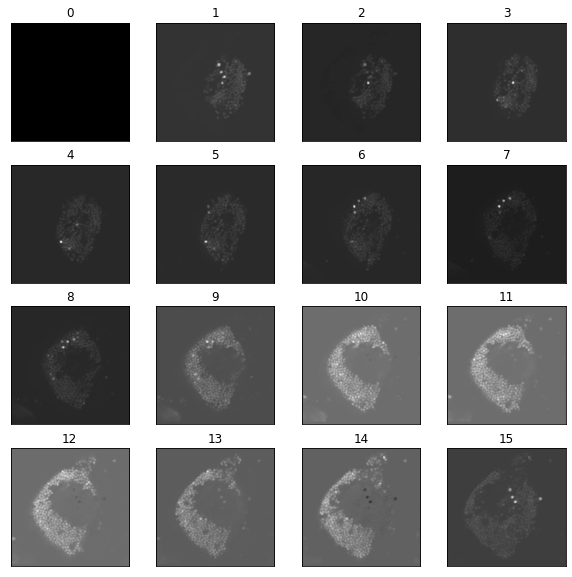

(256, 256, 16)


In [42]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for z, ax in enumerate(axs.flat):
    ax.imshow(mc.total_template_rig[:,:,z], aspect='equal', cmap='gray')
    ax.set_title(str(z))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()
print(mc.total_template_rig.shape)

In [40]:
template_rig = mc.total_template_rig
imsave(MOV_DIR.joinpath('template_rig.tif'), template_rig.T)

AttributeError: 'MotionCorrect' object has no attribute 'total_template_rig'

Text(0, 0.5, 'pixels')

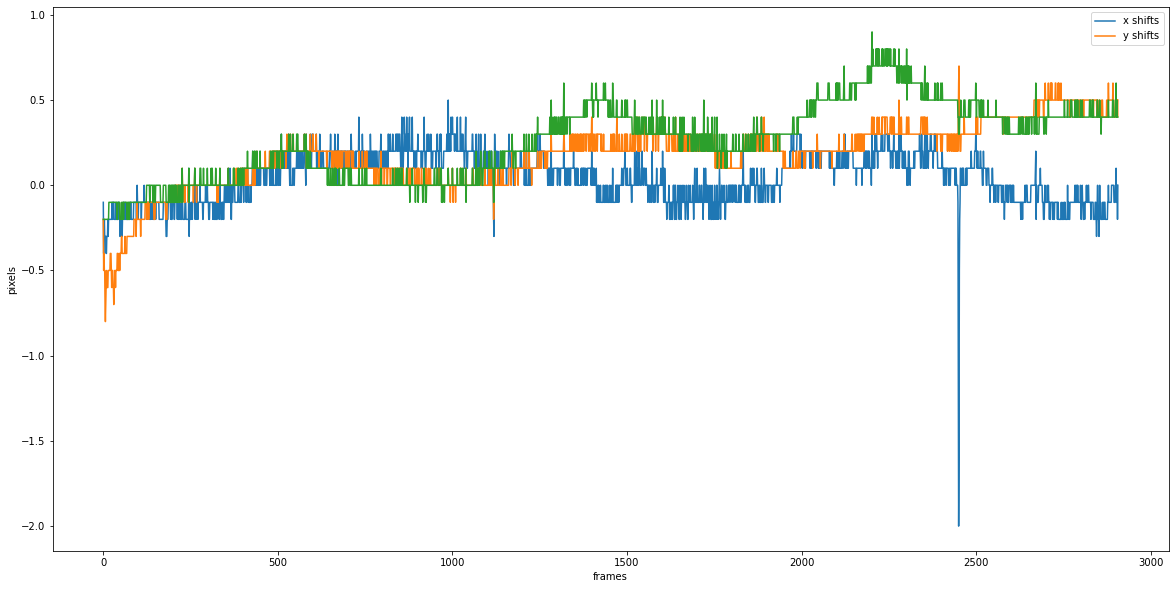

In [32]:
#%% plot rigid shifts
plt.close()
plt.figure(figsize = (20,10))
plt.plot(mc.shifts_rig)
plt.legend(['x shifts','y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels')

In [40]:
## piecewise rigid

#%% motion correct piecewise rigid
mc.pw_rigid = True  # turn the flag to True for pw-rigid motion correction

# use the template obtained before to save in computation (optional)
mc.template = mc.mmap_file  

mc.motion_correct(save_movie=True, template=mc.total_template_rig
                 )
#m_els = cm.load_movie_chain(mc.fname_tot_els)


#%% MEMORY MAPPING
# memory map the file in order 'C'
fname_new = cm.save_memmap(mc.mmap_file, base_name='memmap_', order='C',
                           is_3D=True,
                           border_to_0=0, dview=dview) # exclude borders

# now load the file
Yr, dims, T = cm.load_memmap(fname_new)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
print(images.shape)
#load frames in python format (T x X x Y)

     6201321 [motion_correction.py:motion_correct_pwrigid():355] [9315] Generating template by rigid motion correction
     6201322 [motion_correction.py:motion_correct_rigid():293] [9315] Entering Rigid Motion Correction
     6201322 [motion_correction.py:motion_correct_rigid():294] [9315] -0.0
     6203517 [motion_correction.py:motion_correct_batch_rigid():2816] [9315] Adding to movie -0.0
     6203517 [motion_correction.py:motion_correct_batch_rigid():2822] [9315] 0
     6203518 [motion_correction.py:motion_correct_batch_rigid():2826] [9315] saving!
     6203963 [motion_correction.py:motion_correction_piecewise():3100] [9315] Number of Splits: 12
     6203964 [motion_correction.py:motion_correction_piecewise():3142] [9315] Processing: frames: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 

     6326527 [motion_correction.py:motion_correction_piecewise():3142] [9315] Processing: frames: [405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422
 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440
 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458
 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485]
     6326527 [motion_correction.py:motion_correction_piecewise():3142] [9315] Processing: frames: [486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561 562 563 564 565 566]
     6326528 [motion_correction.py:motion_correction_piecewise():3142] [9315] Processing: frames: [567 568 569 570 571 572 573 574 575 576 577 5

     6427081 [motion_correction.py:motion_correction_piecewise():3142] [9315] Processing: frames: [889 890 891 892 893 894 895 896 897 898 899 900 901 902 903 904 905 906
 907 908 909 910 911 912 913 914 915 916 917 918 919 920 921 922 923 924
 925 926 927 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942
 943 944 945 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960
 961 962 963 964 965 966 967 968]
     6427082 [motion_correction.py:motion_correction_piecewise():3149] [9315] ** Starting parallel motion correction **
     6524153 [motion_correction.py:motion_correction_piecewise():3157] [9315] ** Finished parallel motion correction **
     6524730 [motion_correction.py:motion_correct_batch_pwrigid():2944] [9315] Adding to movie -0.0
     6524731 [motion_correction.py:motion_correct_batch_pwrigid():2947] [9315] 0
     6524732 [motion_correction.py:motion_correct_batch_pwrigid():2957] [9315] saving mmap of /media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Calt

     6835193 [motion_correction.py:motion_correction_piecewise():3142] [9315] Processing: frames: [162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242]
     6835194 [motion_correction.py:motion_correction_piecewise():3142] [9315] Processing: frames: [243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296
 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314
 315 316 317 318 319 320 321 322 323]
     6835195 [motion_correction.py:motion_correction_piecewise():3142] [9315] Processing: frames: [324 325 326 327 328 329 330 331 332 333 334 3

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [48]:
template_rig = mc.total_template_rig


(slice(None, None, None), slice(None, None, None), slice(None, None, None))

In [18]:
print(vars(mc))

{'fname': ["/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0000.tif", "/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0001.tif", "/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0002.tif"], 'dview': <multiprocessing.pool.Pool state=RUN pool_size=11>, 'max_shifts': (4, 4, 2), 'niter_rig': 1, 'splits_rig': 12, 'num_splits_to_process_rig': None, 'strides': (24, 24, 6), 'overlaps': (12, 12, 2), 'splits_els': 12, 'num_splits_to_process_els': None, 'upsample_factor_grid': 4, 'max_deviation_rigid': 5, 'shifts_opencv': True, 'min_mov': 0.0, 'nonneg_movie': True, 'gSig_filt': None, 'use_cuda': False, 'border_nan': 'copy', 'pw_rigid': True, 'var_name_hdf5': 'mov', 'is3D': True, 'indices': (slice(None, None, None), sl

In [35]:
tiff_files

["/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0000.tif",
 "/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0001.tif",
 "/media/remy/remy-storage/Remy's Dropbox Folder/HongLab @ Caltech Dropbox/Remy/mb_odor_rearing/data/processed_data/2021-08-30/2/movie_001/0/cm_0002.tif"]